##Trích dữ liệu
Bài tập lớn: Máy học cơ bản và ứng dụng

Nhóm 10_L01_HK231

Tô Bạch Long_2011559

Tạ Thị Nhã Linh_ 2013642


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Import lib

In [ ]:
import os
import re
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pickle

# !pip install --upgrade tensorflow keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Conv2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

##Trích data .mp3

In [ ]:
data = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/ML/Data_morse/Data_morse/arrl.org-2020-2022'):

    print(dirname)
    if dirname == '/content/drive/MyDrive/ML/Data_morse/Data_morse/arrl.org-2020-2022/2022-30':
        continue

    for filename in filenames:
        if '.mp3' in filename and filename != '220405_20WPM.mp3':
            file = os.path.join(dirname, filename)
            print(filename)
            audio, sr = librosa.load(file)
            data.append(audio)

In [ ]:
#chuyển mp3 thành spectrogram
def create_spectrogram(audio_data):
    spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr)
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return np.array(spectrogram)

#vẽ spectrogram
def plot_spectrogram(spectrogram, start=0, end=-1):
    plt.figure(figsize=(13, 4))
    librosa.display.specshow(spectrogram[:, start:end], sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

In [ ]:
threshold = -15

def silence_detection_bool(spectrogram):
    # Reduce into 1 dimension, if it has -10 in specific column, the value is -10, otherwise -80
    mask_bool = spectrogram < threshold # Under = True = Silence || Above = False = Noise
    word_bool = np.where(np.any(mask_bool, axis=0))[0]
    words = np.split(spectrogram, word_bool, axis=1)

def silence_detection_num(spectrogram, show=False):
    mask_num = np.where(spectrogram < threshold, -80, -10)
    word_num = np.where(np.any(mask_num == -10, axis=0), '-', '.')
#     words = np.split(spectrogram, word_num, axis=1)
    if show:
        text = translate(word_num)
    return mask_num, text

def translate(symbols):
    symbols = ''.join(symbols)
    # Split the morse code into segments of consecutive dots or dashes
    segments = re.findall(r'\.+|-+', symbols)

    # Translate to Morse Code
    morse = ''
    for segment in segments:
        if '.' in segment:
            if len(segment) > 30:
                morse += '|'
            elif len(segment) > 5:
                morse += ' '
        elif '-' in segment:
            if len(segment) < 7:
                morse += '.'
            elif len(segment) >= 7:
                morse += '-'

    # Translate to Alphabetical Text
    ALPHA_TO_MORSE = { 'A':'.-', 'B':'-...',
                    'C':'-.-.', 'D':'-..', 'E':'.',
                    'F':'..-.', 'G':'--.', 'H':'....',
                    'I':'..', 'J':'.---', 'K':'-.-',
                    'L':'.-..', 'M':'--', 'N':'-.',
                    'O':'---', 'P':'.--.', 'Q':'--.-',
                    'R':'.-.', 'S':'...', 'T':'-',
                    'U':'..-', 'V':'...-', 'W':'.--',
                    'X':'-..-', 'Y':'-.--', 'Z':'--..',
                    '1':'.----', '2':'..---', '3':'...--',
                    '4':'....-', '5':'.....', '6':'-....',
                    '7':'--...', '8':'---..', '9':'----.',
                    '0':'-----', ', ':'--..--', '.':'.-.-.-',
                    '?':'..--..', '/':'-..-.', '-':'-....-',
                    '(':'-.--.', ')':'-.--.-', '=':'-...-'}

    MORSE_TO_ALPHA = {'.-': 'A', '-...': 'B',
                      '-.-.': 'C', '-..': 'D', '.': 'E',
                      '..-.': 'F', '--.': 'G', '....': 'H',
                      '..': 'I', '.---': 'J', '-.-': 'K',
                      '.-..': 'L', '--': 'M', '-.': 'N',
                      '---': 'O', '.--.': 'P', '--.-': 'Q',
                      '.-.': 'R', '...': 'S', '-': 'T',
                      '..-': 'U', '...-': 'V', '.--': 'W',
                      '-..-': 'X', '-.--': 'Y', '--..': 'Z',
                      '.----': '1', '..---': '2', '...--': '3',
                      '....-': '4', '.....': '5', '-....': '6',
                      '--...': '7', '---..': '8', '----.': '9',
                      '-----': '0', '--..--': ', ', '.-.-.-': '.',
                      '..--..': '?', '-..-.': '/', '-....-': '-',
                      '-.--.': '(', '-.--.-': ')', '-...-': '='}

    morse_string = morse.strip('|')
    words = morse_string.split('|')
    word_sequences = [word.split(' ') for word in words] # Output: [['-...-'], ['-.', '--', '.--']]

    text = ''
    for word in word_sequences:
        for char in word:
            try:
                text += MORSE_TO_ALPHA[char]
            except KeyError:
                text += '?'
        text += ' '

    return text

In [ ]:
spectrogram_dataset = [create_spectrogram(d) for d in data]

In [ ]:
import pickle
# Lưu dữ liệu vào tệp tin pickle trên máy cục bộ
with open('/content/drive/MyDrive/ML/spectrogram_dataset.pkl', 'wb') as file:
    pickle.dump(spectrogram_dataset, file)

In [ ]:
spectrogram_dataset[0]

array([[-52.074608, -51.616543, -52.560932, ..., -52.561256, -52.34079 ,
        -51.138588],
       [-61.606857, -67.303   , -80.      , ..., -80.      , -78.00952 ,
        -62.72506 ],
       [-65.62836 , -71.67724 , -80.      , ..., -80.      , -80.      ,
        -66.834236],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

##Trích .txt

In [ ]:
import os

data_2 = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/ML/Data_morse/Data_morse/arrl.org-2020-2022'):
    if dirname == '/content/drive/MyDrive/ML/Data_morse/Data_morse/arrl.org-2020-2022/2022-30':
        continue

    for filename in filenames:
        if '.txt' in filename and filename != '220405_20.txt':
            file_path = os.path.join(dirname, filename)
            print(filename)

            with open(file_path, 'r', encoding='latin-1') as file:
                content = file.read()
                data_2.append(content)

In [ ]:
import pickle

# Lưu dữ liệu vào tệp tin pickle trên máy cục bộ

with open('/content/drive/MyDrive/ML/tap_y.pkl', 'wb') as file:
    pickle.dump(data_2, file)

##Ví dụ

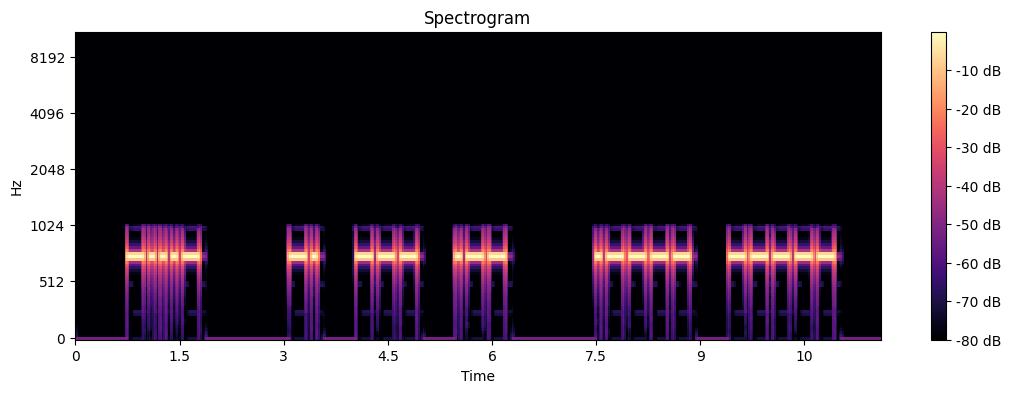

In [ ]:
#mẫu
audio_file = '/content/drive/MyDrive/ML/Data_morse/Data_morse/arrl.org-2020-2022/2020-10/200101_10WPM.mp3'
audio_data, sr = librosa.load(audio_file)

spectrogram = create_spectrogram(audio_data)
plot_spectrogram(spectrogram, end=500)

= NOW 10 WPM = TEXT IS FROM OCTOBER 2018 QST PAGE 78 = 2, 500 YUGOSLAV FIGHTERS AND THE 70, 000 CIVILIANS PREDOMINANTLY SERB,  WHO WERE KILLED OR DEPORTED TO CONCENTRATION CAMPS SEE FIGURE 5. I SPENT AN HOUR ON THE AIR,  AND THEN I RETURNED WITH BOBAN AND HIS DAUGHTER,  WHO EDUCATED ME ON THE COMPLEX HISTORY OF THEIR COUNTRY. EVEN BOBANS PREVIOUS CALL SIGNS REFLECT THIS HISTORY,  STARTING WITH YU4WSO WHEN,  FOLLOWING WORLD = END OF 10 WPM TEXT = QST DE W1AW ? 


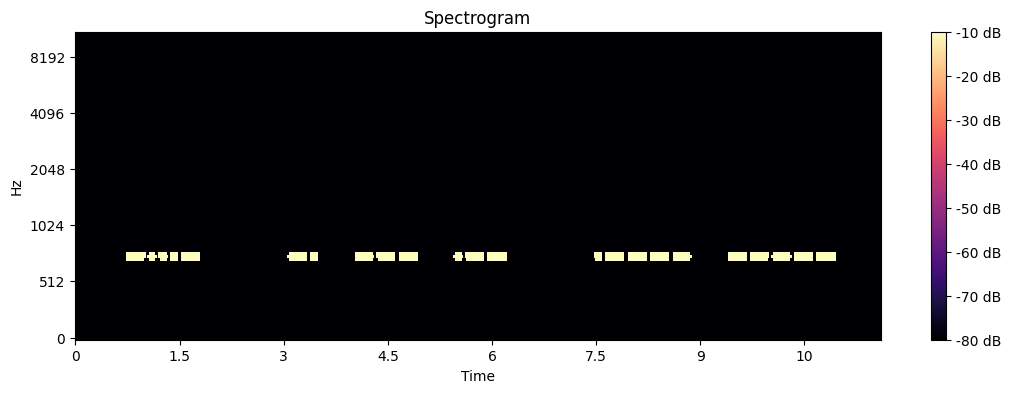

In [ ]:
spec, text = silence_detection_num(spectrogram, show=True)
print(text)
plot_spectrogram(spec, end=500)